<h1 align="center">☁️ - Cloudy regions segmentation 👨‍💻🔬</h1>

<h2 align="center">Modelling - 1st iteration</h2>
<p style="text-align:center">
   Thomas Bury, Afonso Alves, Daniel Staudegger<br>
   Allianz<br>
</p>

* This is the 1st attempt to train and predict the cloud label using **train** data. I'll be using a simple **ANN** to get a baseline performance (later we can do CNN/other algorithms with different preprocessing);  
* To validate the performance of the neural networks, I'll not use the test set, but a new **validation partition** selected from the original train data. The test data will one only be seen when we decide on the final form of the algorithm + preprocessing (<ins>let me know if you guys agree with this</ins>);

In [3]:
import numpy as np 
import pandas as pd
import seaborn as sns
import scicomap as sc
import matplotlib as mpl
import yaml
from pprint import pprint
import cv2
import matplotlib.pyplot as plt
import os

#To get a progress bar for long loops:
from tqdm.notebook import trange, tqdm
from time import sleep

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Custom package for the project, save all the functions into appropriate sub-packages
from pyreidolia.plot import set_my_plt_style, plot_cloud, plot_rnd_cloud, draw_label_only
from pyreidolia.mask import bounding_box, rle_to_mask, get_binary_mask_sum, mask_to_rle
from pyreidolia.img import get_resolution_sharpness

In [4]:
%load_ext autoreload
%autoreload 1

In [5]:
%aimport pyreidolia

## Setting global matplotlib style
If you don't like, just revert back to defaults using `plt.style.use('default')`

In [6]:
# A nicer style for mpl
set_my_plt_style(height=6, width=8, linewidth=1.5)

# A better colormap


sc_map = sc.ScicoSequential(cmap='tropical')
sc_map.unif_sym_cmap(lift=None, 
                     bitonic=False, 
                     diffuse=True)
sc_cmap = sc_map.get_mpl_color_map()

mpl.cm.register_cmap("tropical", sc_cmap)

sc_map = sc.ScicoSequential(cmap='neutral')
sc_map.unif_sym_cmap(lift=None, 
                     bitonic=False, 
                     diffuse=True)
sc_cmap = sc_map.get_mpl_color_map()

mpl.cm.register_cmap("neutral", sc_cmap)

sc_map = sc.ScicoSequential(cmap='neutral_r')
sc_map.unif_sym_cmap(lift=None, 
                     bitonic=False, 
                     diffuse=True)
sc_cmap = sc_map.get_mpl_color_map()

mpl.cm.register_cmap("neutral_r", sc_cmap)

## Load the config file for the paths
To avoid to hardcode the paths in a versioned file, let's create a `paths.yml` which will **not** be versioned. So that the paths are not overwritten when we pull or merge from the GitHub repo. The `paths.yml` should have a structure like:

```yml
# data
data:
  test: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/data/test_images/"
  train: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/data/train_images/"
  docs: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/data/"

# Path to store all notebooks, ideally not versioned
notebooks: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/notebooks/"

# Path to store all outputs (correlations, jsons, excel, etc)
output: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/output/"

# Path to store all python scripts, for versioning
scripts: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/scripts/"

# Path to studies
studies: "C:/Users/xtbury/Documents/Projects/segmentation_cloudy_regions/studies/"

# Path to reports
reports: "C:/Users/xtbury/Documents/Projects/Pyreidolia/reports/"
```

In [7]:
def string_print(df):
    return print(df.to_string().replace('\n', '\n\t'))

In [8]:
# Where is my yaml ? "C:/Users/xtbury/Documents/Projects/Pyreidolia/paths.yml"

paths_yml = input("where is the paths.yml config file?")
with open(paths_yml, "r") as ymlfile:
    path_dic = yaml.load(ymlfile, Loader=yaml.FullLoader)

pprint(path_dic)

where is the paths.yml config file?C:\Users\e400086\Desktop\Docs\DS_Certificate_Sorbonne_and_CV\02_Project_Cloud_Regions\paths.yml
{'data': {'docs': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/00_Docs_and_Links/',
          'test': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/01_Data/test_images/',
          'train': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/01_Data/train_images/'},
 'notebooks': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/03_Notebooks/',
 'output': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/02_Outputs/',
 'reports': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/07_Reports/',
 'scripts': 'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/04_Scripts/',
 'studies': 'C:/Users/e400086

In [9]:
train_csv_path = path_dic['data']['docs'] + 'train.csv'
train_pq_path = path_dic['data']['docs'] + "train_info_clean.parquet"
train_data = path_dic['data']['train'] 
test_data = path_dic['data']['test'] 
report_path = path_dic['reports']

In [10]:
train_doc = pd.read_parquet(train_pq_path)
train_doc.head(3)

,image_label,encoded_pixels,image_id,label,label_encodedpix,is_mask,mask_pixel_sum,resolution,sharpness,quality
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,"[Fish, 264918 937 266318 937 267718 937 269118...",True,932312.0,"[1400, 2100, 3]",26.944502,good
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,"[Flower, 1355565 1002 1356965 1002 1358365 100...",True,1156107.0,"[1400, 2100, 3]",26.944502,good
2,0011165.jpg_Gravel,None,0011165.jpg,Gravel,"[Gravel, None]",False,NaN,"[1400, 2100, 3]",26.944502,good


## Preprocessing - 1st iteration  
For this iteration, I'm going to do the following configuration:  
**1) convert image to gray_scale:**
```python
img_gray = cv2.imread(os.path.join(train_data, image_name), cv2.IMREAD_GRAYSCALE)
```  
**2) apply binary threshold**; each pixel can only be white or blask; **`threshold = 150/255`**;
```python
_, img_gray = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)
```  
**3) apply gaussian blur**, using class kernel size `(3,3)`;
```python
gb_filter = cv2.GaussianBlur(img_gray, ksize=(3, 3), sigmaX=0, sigmaY=0)
```  
**4) erode image** - this is like fading out/degrade the image, using class kernel size `(3,3)`;
```python
erosion = cv2.erode(gb_filter,kernel)
```  
**5) dilate image** - this kinda increases the pixel intensity of low intensity pixels (see example in pre-treatment for this one). Kernel is a 7x7 matrix:
```python
kernel = np.ones((7, 7), np.uint8)
dilation = cv2.dilate(erosion, kernel)
```  
**6) subtract background** - to me this looks like a "complex" binary threshold:  
```python
backSub = cv2.createBackgroundSubtractorMOG2() #cv2.createBackgroundSubtractorKNN()
fg_mask = backSub.apply(dilation)
```  

**just a thought 💭:** we could in theory use two images (with **{preproc_1}** and **{preproc_2}**) at the same time and feed the **double configuration** to a neural networks... at the expense of higher computational time... unless one or both images are rescaled down.  

One missing variable is the scale of the processed images. Let's create a function and try multiple shapes to see what happens to the output:

In [10]:
def preproc_1(image_name, train_data, row_px, col_px):
    #1) Read image to gray_scale:
    img_gray = cv2.imread(os.path.join(train_data, image_name), cv2.IMREAD_GRAYSCALE)
    
    #1.1) Resize from (2100, 1400) to (row_px, col_px):
    img_gray = cv2.resize(img_gray, (row_px,col_px))
    
    #2) Apply binary threshold of 150:
    _, img_gray = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)
    
    #3) Apply gaussian blur, using class kernel size (3,3):
    gb_filter = cv2.GaussianBlur(img_gray, ksize=(3, 3), sigmaX=0, sigmaY=0)
    
    #4) Erode image, using a 7x7 kernel matrix:
    kernel = np.ones((7, 7), np.uint8)
    erosion = cv2.erode(gb_filter,kernel)
    
    #5) Dilate image, using the same 7x7 kernel matrix:
    dilation = cv2.dilate(erosion, kernel)
    
    #6) Subtract background (MOG2):
    backSub = cv2.createBackgroundSubtractorMOG2() #cv2.createBackgroundSubtractorKNN()
    fg_mask = backSub.apply(dilation)
    
    return fg_mask

### What shape?  
Each image is array with original shape (1400, 2100, 1) (1 because it's gray scaled already for preproc_1). Ideally, one would keep the original shape, but such could create a very high training time. As a solution, we can compress the row and column pixels by a common factor, to keep the aspect ratio (e.g. by six, $(\frac{1400}{6}, \frac{2100}{6})$ = (233, 350)).  
Let's try some shapes:

In [11]:
shape_list_row = [int(np.ceil(2100/1)), int(np.ceil(2100/1.5)), int(np.ceil(2100/2)), int(np.ceil(2100/2.5)),
                  int(np.ceil(2100/3)), int(np.ceil(2100/3.5)), int(np.ceil(2100/4)), int(np.ceil(2100/4.5))]
shape_list_col = [int(np.ceil(1400/1)), int(np.ceil(1400/1.5)), int(np.ceil(1400/2)), int(np.ceil(1400/2.5)),
                  int(np.ceil(1400/3)), int(np.ceil(1400/3.5)), int(np.ceil(1400/4)), int(np.ceil(1400/4.5))]

See the pre-processing and teh effect of different shapes on the first image of train:

In [12]:
image_name = train_doc.image_id[0]
image_start = plt.imread(os.path.join(train_data, image_name))

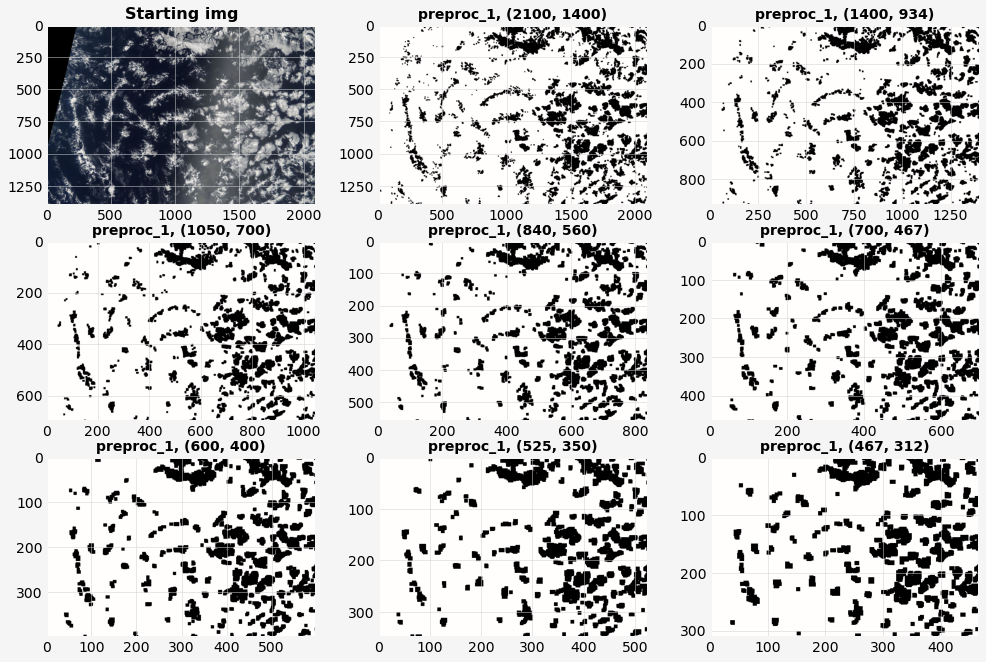

In [13]:
fig = plt.figure(figsize=(15, 10.5))
subplot_aux = 1
fig.add_subplot(3, 3, subplot_aux)
plt.imshow(image_start)
plt.title('Starting img' , fontproperties={'size':16, 'weight':'bold'})

for row_rscl, col_rscl in zip(shape_list_row, shape_list_col):
    subplot_aux += 1
    fig.add_subplot(3, 3, subplot_aux)
    
    fg_mask = preproc_1(image_name, train_data, row_rscl, col_rscl)
    plt.imshow(fg_mask, cmap='neutral')
    plt.title('preproc_1, (%.0f, %.0f)' % (row_rscl, col_rscl), fontproperties={'size':14, 'weight':'bold'})
plt.show();

... this is very subjective, but the **(700, 467)** seems to offer a reasonable balance between resolution and pixel count. But there's no actual way to guess the training time, or if this is a good choice. Only by testing the NN.

## Create train and valid sets  
Like I said at the beginning, I think it's a good idea to save the test data for later, and create new validation partition from the original train. Hence, we will create `X_train2`, `y_train2`, `X_valid2`, `y_valid2`.  

**Note:** probably not clever to do cross-validation like normal ML; training multiple NN seems unwise. 

The train has 5546 images and test has 3698 images, making it train/test = **60%/40%**.  

**just a thought 💭:** we could pass like 10% of test images to train, making it **70%/30%**, and from this train create X_train2/X_valid2/X_test = **50%/20%/30%**. Maybe this could something we can do in future iterations...  

But for now going to do X_train2/X_valid2/X_test = **45%/15%/40%** (not using the test data).

In [13]:
#Get unique image ids (e.g '0011165.jpg') of train:
image_train_unique = pd.DataFrame({'image_id':train_doc.image_id.value_counts().index.to_list()})

In [14]:
Img_train2 = image_train_unique.sample(frac=0.75,random_state=42)
Img_valid2 = image_train_unique.drop(Img_train2.index)
print(">> Original train with %.f unique images was divided into Img_train2 and Img_valid2 with %.f and %.f images."
     % (len(image_train_unique), len(Img_train2), len(Img_valid2)))

>> Original train with 5546 unique images was divided into Img_train2 and Img_valid2 with 4160 and 1386 images.


Notice that I didn't use `train_test_split`, because it's not so simple to obtain the y_train2 / y_valid2 arrays...  
**Note:** dividing train by 0.75/0.25 is equivalent to splitting the 60% total into 45% and 15%.

### > Create `X_train2` and `X_valid2` from `Img_train2` and `Img_valid2`  
For each image of `Img_train2` and `Img_valid2`, apply **`preproc_1()`** with **shape = (700, 467)**. Then, save the rescaled image as a vector with len = 700*467 = 326900. Gather all vectors into a vector of vectors, named `X_train2` and `X_valid2`.  

**Note:** `Img_train2` and `Img_valid2` are DataFrames with a column named `image_id` (unique values).

In [15]:
row_px, col_px = 700, 467 #setup target dims
train_data

'C:/Users/e400086/Desktop/Docs/DS_Certificate_Sorbonne_and_CV/02_Project_Cloud_Regions/01_Data/train_images/'

**>>** Example using **np.empty** that I adapted for the next cell: https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-119.php  
**>>** For more information about **tqdm** package: https://github.com/tqdm/tqdm/#ipython-jupyter-integration  
**>>** To apply the **`preproc_1()`** to every image of `Img_train2` I could use pandas `.apply()`, but found this: https://stackoverflow.com/questions/38938318/why-apply-sometimes-isnt-faster-than-for-loop-in-pandas-dataframe  
The following loops take a while:

In [ ]:
#>> Img_train2:
#Create empty array with 0 lines and the correct number of columns:
X_train2 = np.empty((0, row_px*col_px), int)
#Now I can do things like appending other line arrays.

for img_id in tqdm(Img_train2.image_id.to_list(), desc='Preprocessing -> X_train2'):
    #Apply the preproc_1 function to each img_id (the function gets from the path the image array):
    img_prep_rscl = preproc_1(img_id, train_data, row_px, col_px)

    #Convert (700, 467) array into (326900,):
    img_prep_rscl_vec = img_prep_rscl.reshape([-1, row_px*col_px])
    #plt.imshow(img_prep_rscl_vec, cmap='neutral')

    #Add vector to X_train2:
    X_train2 = np.append(X_train2, img_prep_rscl_vec, axis=0)

_This took me 1h16min to run._

In [115]:
print(">> X_train2 shape:", X_train2.shape)
print(">> X_train2 memory size: %.f bytes / %.2f Mb / %.2f Gb."
      % (X_train2.nbytes, X_train2.nbytes*1.0*10**(-6), X_train2.nbytes*1.0*10**(-9)))

>> X_train2 shape: (4160, 326900)
>> X_train2 memory size: 5439616000 bytes / 5439.62 Mb / 5.44 Gb.


In [104]:
#>> Img_valid2:
#Create empty array with 0 lines and the correct number of columns:
X_valid2 = np.empty((0, row_px*col_px), int)
#Now I can do things like appending other line arrays.

for img_id in tqdm(Img_valid2.image_id.to_list(), desc='Preprocessing -> X_valid2'):
    #Apply the preproc_1 function to each img_id (the function gets from the path the image array):
    img_prep_rscl = preproc_1(img_id, train_data, row_px, col_px)

    #Convert (700, 467) array into (326900,):
    img_prep_rscl_vec = img_prep_rscl.reshape([-1, row_px*col_px])
    #plt.imshow(img_prep_rscl_vec, cmap='neutral')

    #Add vector to X_train2:
    X_valid2 = np.append(X_valid2, img_prep_rscl_vec, axis=0)

Preprocessing -> X_valid2:   0%|          | 0/1386 [00:00<?, ?it/s]

_This took me 9min to run._

In [116]:
print(">> X_valid2 shape:", X_valid2.shape)
print(">> X_valid2 memory size: %.f bytes / %.2f Mb / %.2f Gb."
      % (X_valid2.nbytes, X_valid2.nbytes*1.0*10**(-6), X_valid2.nbytes*1.0*10**(-9)))

>> X_train2 shape: (1386, 326900)
>> X_valid2 memory size: 1812333600 bytes / 1812.33 Mb / 1.81 Gb.


Save numpy arrays to avoid recomputing everything. Saving to `path_dic['data']['docs']`:   

 **Note:** you need a total of 5.44 Gb + 1.81 Gb = **7.25 Gb** of free space.

In [117]:
#Save X_train2:
with open(path_dic['data']['docs'] + 'X_train2.npy', 'wb') as f:
    np.save(f, X_train2)

In [ ]:
#Save X_train2 image_ids and indices: 
with open(path_dic['data']['docs'] + 'Img_train2.pkl', 'wb') as f:
    Img_train2.to_pickle(f)

In [118]:
#Save X_valid2:
with open(path_dic['data']['docs'] + 'X_valid2.npy', 'wb') as f:
    np.save(f, X_valid2)

In [ ]:
#Save X_valid2 image_ids and indices: 
with open(path_dic['data']['docs'] + 'Img_valid2.pkl', 'wb') as f:
    Img_valid2.to_pickle(f)

### > Create `y_train2` and `y_valid2` from `Img_train2` and `Img_valid2`
The target structure varies with the type of problem we are considering:  
* **Image classification:** determine the cloud types present in the image. It's a multilabel problem, with just one _set_ of classes per image (e.g. y_train2[0] = ('Gravel', 'Sugar') or ('Flower) or (None). Another (simpler) possible solution is to convert the problem into a multiclass problem: softmax problem with all possible label combinations: ${}_4C_1$ + ${}_4C_2$ + ${}_4C_3$ + ${}_4C_4$ = 4 + 6 + 4 + 1 = 15 labels (${}_nC_r$: combinations without order of $n$ elements choosing a $r$ subset); 

* **Object detection:** basically the same nature as the image classification problem, but we also want to associate to each predicted cloud label a bounding box corresponding to the location of the cloud type in the image. If $pred\_n\_lab$ is the number of labels predicted in the image, we have an additional $pred\_n\_lab \times 4$ continuous variables to predict: the center location $(x_{bb}, y_{bb})$, the $length_{bb}$ and $height_{bb}$ of the bbox. Each quartet of continous variables is only non-zero if the cloud was predicted in the first place. Maybe there's a way to do a binary layer -> ({predicted labels}) --> ([if label in {predicted labels}] Regression layer with 4 dimensions)x4. Why can't we just tell the NN to predict a single (4x4) continuous array (4 dimensions x 4 possible labels)? I suspect because we could have inconsistent predictions, like having $Output = \{[x_{bb}, y_{bb}, length_{bb}, height_{bb}]_{Flower} = [>0, >0, =0, >0]$, $[x_{bb}, y_{bb}, length_{bb}, height_{bb}]_{Gravel} = [=0, >0, =0, =0]$, $[x_{bb}, y_{bb}, length_{bb}, height_{bb}]_{Sugar} = [=0, =0, =0, =0]$, $[x_{bb}, y_{bb}, length_{bb}, height_{bb}]_{Fish} = [>0, >0, >0, >0]\}$. To avoid this, I think we need at least to code the previously mentioned dependencies.

**Note:** instead of $[x_{bb,\, center},\, y_{bb,\, center},\, length_{bb},\, height_{bb}]$, we can have something like $[x_{bb,\, top\, right},\, y_{bb,\, top\, right},\, x_{bb,\, bottom\, left},\, y_{bb,\, bottom\, left}]$.

* **Semantic segmentation**: ...

#### >> Image classification: target labels for train/valid
Assuming a mapping convention like $['Fish', 'Flower', 'Gravel', 'Sugar']$ => $[bin_{Fish}, bin_{Flower}, bin_{Gravel}, bin_{Sugar}]$. Create the train and valid labels for image classification: **`y_train2_IC`** and **`y_valid2_IC`**.

In [43]:
#>> Img_train2:
#Create empty array with 0 lines and the correct number of columns:
y_train2_IC = np.empty((0, 4), int)

for img_id in tqdm(Img_train2.image_id.to_list(), desc='Generating y_train2_IC'):
    
    #1) Fish:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Fish'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Fish')].is_mask.values[0]: #boolean condition
        bin_Fish = 1
    else:
        bin_Fish = 0
        
    #2) Flower:
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Flower')].is_mask.values[0]: #boolean condition
        bin_Flower = 1
    else:
        bin_Flower = 0
    
    #3) Gravel:
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Gravel')].is_mask.values[0]: #boolean condition
        bin_Gravel = 1
    else:
        bin_Gravel = 0
    
    #4) Sugar:
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Sugar')].is_mask.values[0]: #boolean condition
        bin_Sugar = 1
    else:
        bin_Sugar = 0
        
    target_label = np.array([[bin_Fish, bin_Flower, bin_Gravel, bin_Sugar]])
    
    y_train2_IC = np.append(y_train2_IC, target_label, axis=0)

Generating y_train2_IC:   0%|          | 0/4160 [00:00<?, ?it/s]

In [44]:
print(">> y_train2_IC shape:", y_train2_IC.shape)
print(">> y_train2_IC memory size: %.f bytes / %.2f Mb / %.2f Gb."
      % (y_train2_IC.nbytes, y_train2_IC.nbytes*1.0*10**(-6), y_train2_IC.nbytes*1.0*10**(-9)))

>> y_train2_IC shape: (4160, 4)
>> y_train2_IC memory size: 66560 bytes / 0.07 Mb / 0.00 Gb.


In [45]:
#>> Img_valid2:
#Create empty array with 0 lines and the correct number of columns:
y_valid2_IC = np.empty((0, 4), int)

for img_id in tqdm(Img_valid2.image_id.to_list(), desc='Generating y_valid2_IC'):
    
    #1) Fish:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Fish'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Fish')].is_mask.values[0]: #boolean condition
        bin_Fish = 1
    else:
        bin_Fish = 0
        
    #2) Flower:
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Flower')].is_mask.values[0]: #boolean condition
        bin_Flower = 1
    else:
        bin_Flower = 0
    
    #3) Gravel:
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Gravel')].is_mask.values[0]: #boolean condition
        bin_Gravel = 1
    else:
        bin_Gravel = 0
    
    #4) Sugar:
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Sugar')].is_mask.values[0]: #boolean condition
        bin_Sugar = 1
    else:
        bin_Sugar = 0
        
    target_label = np.array([[bin_Fish, bin_Flower, bin_Gravel, bin_Sugar]])
    
    y_valid2_IC = np.append(y_valid2_IC, target_label, axis=0)

Generating y_valid2_IC:   0%|          | 0/1386 [00:00<?, ?it/s]

In [46]:
print(">> y_valid2_IC shape:", y_valid2_IC.shape)
print(">> y_valid2_IC memory size: %.f bytes / %.2f Mb / %.2f Gb."
      % (y_valid2_IC.nbytes, y_valid2_IC.nbytes*1.0*10**(-6), y_valid2_IC.nbytes*1.0*10**(-9)))

>> y_valid2_IC shape: (1386, 4)
>> y_valid2_IC memory size: 22176 bytes / 0.02 Mb / 0.00 Gb.


Save numpy arrays to avoid recomputing everything. Saving to `path_dic['data']['docs']`:   

In [47]:
#Save y_train2_IC:
with open(path_dic['data']['docs'] + 'y_train2_IC.npy', 'wb') as f:
    np.save(f, y_train2_IC)

In [48]:
#Save y_valid2_IC:
with open(path_dic['data']['docs'] + 'y_valid2_IC.npy', 'wb') as f:
    np.save(f, y_valid2_IC)

**Note:** after saving, delete to free up space:

In [ ]:
del y_train2_IC

In [ ]:
del y_valid2_IC

#### >> Object detection: target labels for train/valid
Assuming a mapping convention like $[x_{center,\; bb},\; y_{center,\; bb},\; length_{bb},\; height_{bb}]$, associated with each label. Thus the target array, **`y_train2_OD`** and **`y_train2_OD`**, will have, for each image `i`, a set of arrays:  
```python
y_train2_OD[i] = np.array([[x,y,l,h]_Fish,[x,y,l,h]_Gravel,[x,y,h,l]_Flower,[x,y,h,l]_Sugar])
```

**Note:** this is the base form of the target vector. Changes to the vector, if convenient, can be maid later.

In [85]:
def mask_xyhl(mask): #find (x,y) center and height, lenght
    temp1 = mask.sum(axis=0)
    flag_col = 0
    for idx, col_sum in enumerate(temp1):
        if col_sum != 0 and flag_col == 0:
            min_x = idx
            flag_col = 1

    flag_col_flp = 0
    for idx_flp, col_sum_flp in enumerate(np.flip(temp1)):
        if col_sum_flp != 0 and flag_col_flp == 0:
            max_x = len(temp1) - idx_flp
            flag_col_flp = 1

    temp2 = mask.sum(axis=1)
    flag_row = 0
    for idx, row_sum in enumerate(temp2):
        if row_sum != 0 and flag_row == 0:
            min_y = idx
            flag_row = 1

    flag_row_flp = 0
    for idx_flp, row_sum_flp in enumerate(np.flip(temp2)):
        if row_sum_flp != 0 and flag_row_flp == 0:
            max_y = len(temp2) - idx_flp
            flag_row_flp = 1
        
    #From min_x, max_x, min_y, max_y:
    x_center = (max_x - min_x)/2
    y_center = (max_y - min_y)/2
    length = max_x - min_x
    heigth = max_x - min_x
            
    return x_center, y_center, length, heigth

In [90]:
#>> Img_train2:
#Create empty array with 0 lines and the correct number of columns:
y_train2_OD = np.empty((0, 4, 4), float)

for img_id in tqdm(Img_train2.image_id.to_list(), desc='Generating y_train2_OD'):
    
    bin_Fish, bin_Flower, bin_Gravel, bin_Sugar = 0,0,0,0
    
    #Default values:
    target4_Fish = np.array([0,0,0,0])
    target4_Flower = np.array([0,0,0,0])
    target4_Gravel = np.array([0,0,0,0])
    target4_Sugar = np.array([0,0,0,0])
    
    #1) Fish:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Fish'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Fish')].is_mask.values: #boolean condition
        #Get the fish mask:
        fish_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Fish')].encoded_pixels.values[0])
        #Resize mask:
        fish_mask_rscl = cv2.resize(fish_mask, (row_px,col_px))
        bin_Fish = 1
        
        #Find x_center, y_center, length, heigth:
        x_center, y_center, length, heigth = mask_xyhl(fish_mask_rscl)
        target4_Fish = np.array([x_center, y_center, length, heigth])
    
    #2) Flower:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Flower'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Flower')].is_mask.values: #boolean condition
        #Get the fish mask:
        flower_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Flower')].encoded_pixels.values[0])
        #Resize mask:
        flower_mask_rscl = cv2.resize(flower_mask, (row_px,col_px))
        bin_Flower = 1
        
        #Find x_center, y_center, length, heigth:
        x_center, y_center, length, heigth = mask_xyhl(flower_mask_rscl)
        target4_Flower = np.array([x_center, y_center, length, heigth])
        
    #3) Gravel:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Gravel'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Gravel')].is_mask.values: #boolean condition
        #Get the fish mask:
        gravel_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Gravel')].encoded_pixels.values[0])
        #Resize mask to (row_px,col_px):
        gravel_mask_rscl = cv2.resize(gravel_mask, (row_px,col_px))
        bin_Gravel = 1
        
        #Find x_center, y_center, length, heigth:
        x_center, y_center, length, heigth = mask_xyhl(gravel_mask_rscl)
        target4_Gravel = np.array([x_center, y_center, length, heigth])
        
    #4) Sugar:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Sugar'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Sugar')].is_mask.values: #boolean condition
        #Get the fish mask:
        sugar_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Sugar')].encoded_pixels.values[0])
        #Resize mask:
        sugar_mask_rscl = cv2.resize(sugar_mask, (row_px,col_px))
        bin_Sugar = 1
        
        #Find x_center, y_center, length, heigth:
        x_center, y_center, length, heigth = mask_xyhl(sugar_mask_rscl)
        target4_Sugar = np.array([x_center, y_center, length, heigth])
        
    #Aggregate all target labels into a single vector:
    target4_agg = np.array([[target4_Fish,target4_Flower,target4_Gravel,target4_Sugar]])
    y_train2_OD = np.append(y_train2_OD, target4_agg, axis=0)


Generating y_train2_OD:   0%|          | 0/4160 [00:00<?, ?it/s]

In [91]:
print(">> y_train2_OD shape:", y_train2_OD.shape)

>> y_train2_OD shape: (4160, 4, 4)


In [92]:
#>> Img_valid2:
#Create empty array with 0 lines and the correct number of columns:
y_valid2_OD = np.empty((0, 4, 4), float)

for img_id in tqdm(Img_valid2.image_id.to_list(), desc='Generating y_train2_OD'):
    
    bin_Fish, bin_Flower, bin_Gravel, bin_Sugar = 0,0,0,0
    
    #Default values:
    target4_Fish = np.array([0,0,0,0])
    target4_Flower = np.array([0,0,0,0])
    target4_Gravel = np.array([0,0,0,0])
    target4_Sugar = np.array([0,0,0,0])
    
    #1) Fish:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Fish'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Fish')].is_mask.values: #boolean condition
        #Get the fish mask:
        fish_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Fish')].encoded_pixels.values[0])
        #Resize mask:
        fish_mask_rscl = cv2.resize(fish_mask, (row_px,col_px))
        bin_Fish = 1
        
        #Find x_center, y_center, length, heigth:
        x_center, y_center, length, heigth = mask_xyhl(fish_mask_rscl)
        target4_Fish = np.array([x_center, y_center, length, heigth])
    
    #2) Flower:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Flower'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Flower')].is_mask.values: #boolean condition
        #Get the fish mask:
        flower_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Flower')].encoded_pixels.values[0])
        #Resize mask:
        flower_mask_rscl = cv2.resize(flower_mask, (row_px,col_px))
        bin_Flower = 1
        
        #Find x_center, y_center, length, heigth:
        x_center, y_center, length, heigth = mask_xyhl(flower_mask_rscl)
        target4_Flower = np.array([x_center, y_center, length, heigth])
        
    #3) Gravel:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Gravel'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Gravel')].is_mask.values: #boolean condition
        #Get the fish mask:
        gravel_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Gravel')].encoded_pixels.values[0])
        #Resize mask to (row_px,col_px):
        gravel_mask_rscl = cv2.resize(gravel_mask, (row_px,col_px))
        bin_Gravel = 1
        
        #Find x_center, y_center, length, heigth:
        x_center, y_center, length, heigth = mask_xyhl(gravel_mask_rscl)
        target4_Gravel = np.array([x_center, y_center, length, heigth])
        
    #4) Sugar:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Sugar'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Sugar')].is_mask.values: #boolean condition
        #Get the fish mask:
        sugar_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Sugar')].encoded_pixels.values[0])
        #Resize mask:
        sugar_mask_rscl = cv2.resize(sugar_mask, (row_px,col_px))
        bin_Sugar = 1
        
        #Find x_center, y_center, length, heigth:
        x_center, y_center, length, heigth = mask_xyhl(sugar_mask_rscl)
        target4_Sugar = np.array([x_center, y_center, length, heigth])
        
    #Aggregate all target labels into a single vector:
    target4_agg = np.array([[target4_Fish,target4_Flower,target4_Gravel,target4_Sugar]])
    y_valid2_OD = np.append(y_valid2_OD, target4_agg, axis=0)

Generating y_train2_OD:   0%|          | 0/1386 [00:00<?, ?it/s]

In [93]:
print(">> y_valid2_OD shape:", y_valid2_OD.shape)

>> y_valid2_OD shape: (1386, 4, 4)


Save numpy arrays to avoid recomputing everything. Saving to `path_dic['data']['docs']`:  

In [94]:
#Save y_train2_OD:
with open(path_dic['data']['docs'] + 'y_train2_OD.npy', 'wb') as f:
    np.save(f, y_train2_OD)

In [95]:
#Save y_valid2_OD:
with open(path_dic['data']['docs'] + 'y_valid2_OD.npy', 'wb') as f:
    np.save(f, y_valid2_OD)

#### >> Semantic segmentation: target labels for train/valid  
##### 1 image -> 4 label maks

In [78]:
row_px, col_px = int(np.ceil(2100/5)), int(np.ceil(1400/5))
print(row_px, col_px)

In [ ]:
y_train2_SS = np.empty((0, 4, row_px*col_px), int)

cnt_big_iter = 0
cnt_small_iter = 0
for img_id in tqdm(Img_train2.image_id.to_list(), desc='Generating y_train2_OD'):
    
    cnt_small_iter += 1
    
    bin_Fish, bin_Flower, bin_Gravel, bin_Sugar = 0,0,0,0
    
    #Default values:
    fish_mask_rscl_vec = np.zeros(shape=(row_px*col_px,))
    flower_mask_rscl_vec = np.zeros(shape=(row_px*col_px,))
    gravel_mask_rscl_vec = np.zeros(shape=(row_px*col_px,))
    sugar_mask_rscl_vec = np.zeros(shape=(row_px*col_px,))
    
    #1) Fish:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Fish'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Fish')].is_mask.values: #boolean condition
        #Get the fish mask:
        fish_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Fish')].encoded_pixels.values[0])
        #Resize mask:
        fish_mask_rscl = cv2.resize(fish_mask, (row_px,col_px))
        bin_Fish = 1
        
        #Unravel to a single vector the 2 array mask:
        fish_mask_rscl_vec = fish_mask_rscl.reshape(-1,(row_px*col_px))[0]
    
    #2) Flower:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Flower'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Flower')].is_mask.values: #boolean condition
        #Get the fish mask:
        flower_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Flower')].encoded_pixels.values[0])
        #Resize mask:
        flower_mask_rscl = cv2.resize(flower_mask, (row_px,col_px))
        bin_Flower = 1
        
        #Unravel to a single vector the 2 array mask:
        flower_mask_rscl_vec = flower_mask_rscl.reshape(-1,(row_px*col_px))[0]
        
    #3) Gravel:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Gravel'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Gravel')].is_mask.values: #boolean condition
        #Get the fish mask:
        gravel_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Gravel')].encoded_pixels.values[0])
        #Resize mask to (row_px,col_px):
        gravel_mask_rscl = cv2.resize(gravel_mask, (row_px,col_px))
        bin_Gravel = 1
        
        #Unravel to a single vector the 2 array mask:
        gravel_mask_rscl_vec = gravel_mask_rscl.reshape(-1,(row_px*col_px))[0]
        
    #4) Sugar:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Sugar'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Sugar')].is_mask.values: #boolean condition
        #Get the fish mask:
        sugar_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Sugar')].encoded_pixels.values[0])
        #Resize mask:
        sugar_mask_rscl = cv2.resize(sugar_mask, (row_px,col_px))
        bin_Sugar = 1
        
        #Unravel to a single vector the 2 array mask:
        sugar_mask_rscl_vec = sugar_mask_rscl.reshape(-1,(row_px*col_px))[0]
        
    #Aggregate all target masks into a single vector:
    mask4_agg = np.array([[fish_mask_rscl_vec,flower_mask_rscl_vec,gravel_mask_rscl_vec,sugar_mask_rscl_vec]])
    y_train2_SS = np.append(y_train2_SS, mask4_agg, axis=0)
    
    #Once I reach 100 images, save current progress and delete current arrays:
    if cnt_small_iter == 100:
        cnt_small_iter = 0
        with open(path_dic['data']['docs'] + 'y_train2_SS' + str(cnt_big_iter) + '.npy', 'wb') as f:
            np.save(f, y_train2_SS)
        cnt_big_iter += 1
        
        del y_train2_SS, fish_mask_rscl_vec,flower_mask_rscl_vec,gravel_mask_rscl_vec,sugar_mask_rscl_vec
        y_train2_SS = np.empty((0, 4, row_px*col_px), int)

Generating y_train2_OD:   0%|          | 0/4160 [00:00<?, ?it/s]

In [ ]:
print(">> y_train2_SS shape:", y_train2_SS.shape)

In [ ]:
y_valid2_SS = np.empty((0, 4, row_px*col_px), int)

cnt_big_iter = 0
cnt_small_iter = 0
for img_id in tqdm(Img_valid2.image_id.to_list(), desc='Generating y_train2_OD'):
    
    bin_Fish, bin_Flower, bin_Gravel, bin_Sugar = 0,0,0,0
    
    #Default values:
    fish_mask_rscl_vec = np.zeros(shape=(row_px*col_px,))
    flower_mask_rscl_vec = np.zeros(shape=(row_px*col_px,))
    gravel_mask_rscl_vec = np.zeros(shape=(row_px*col_px,))
    sugar_mask_rscl_vec = np.zeros(shape=(row_px*col_px,))
    
    #1) Fish:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Fish'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Fish')].is_mask.values: #boolean condition
        #Get the fish mask:
        fish_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Fish')].encoded_pixels.values[0])
        #Resize mask:
        fish_mask_rscl = cv2.resize(fish_mask, (row_px,col_px))
        bin_Fish = 1
        
        #Unravel to a single vector the 2 array mask:
        fish_mask_rscl_vec = fish_mask_rscl.reshape(-1,(row_px*col_px))[0]
    
    #2) Flower:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Flower'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Flower')].is_mask.values: #boolean condition
        #Get the fish mask:
        flower_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Flower')].encoded_pixels.values[0])
        #Resize mask:
        flower_mask_rscl = cv2.resize(flower_mask, (row_px,col_px))
        bin_Flower = 1
        
        #Unravel to a single vector the 2 array mask:
        flower_mask_rscl_vec = flower_mask_rscl.reshape(-1,(row_px*col_px))[0]
        
    #3) Gravel:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Gravel'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Gravel')].is_mask.values: #boolean condition
        #Get the fish mask:
        gravel_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Gravel')].encoded_pixels.values[0])
        #Resize mask to (row_px,col_px):
        gravel_mask_rscl = cv2.resize(gravel_mask, (row_px,col_px))
        bin_Gravel = 1
        
        #Unravel to a single vector the 2 array mask:
        gravel_mask_rscl_vec = gravel_mask_rscl.reshape(-1,(row_px*col_px))[0]
        
    #4) Sugar:
    #See if value of column is_mask == True, for image_id = imd_id and label = 'Sugar'
    if train_doc[(train_doc.image_id == img_id) & (train_doc.label == 'Sugar')].is_mask.values: #boolean condition
        #Get the fish mask:
        sugar_mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                (train_doc.label == 'Sugar')].encoded_pixels.values[0])
        #Resize mask:
        sugar_mask_rscl = cv2.resize(sugar_mask, (row_px,col_px))
        bin_Sugar = 1
        
        #Unravel to a single vector the 2 array mask:
        sugar_mask_rscl_vec = sugar_mask_rscl.reshape(-1,(row_px*col_px))[0]
        
    #Aggregate all target masks into a single vector:
    mask4_agg = np.array([[fish_mask_rscl_vec,flower_mask_rscl_vec,gravel_mask_rscl_vec,sugar_mask_rscl_vec]])
    y_valid2_SS = np.append(y_valid2_SS, mask4_agg, axis=0)
    
    #Once I reach 100 images, save current progress and delete current arrays:
    if cnt_small_iter == 100:
        cnt_small_iter = 0
        with open(path_dic['data']['docs'] + 'y_valid2_SS' + str(cnt_big_iter) + '.npy', 'wb') as f:
            np.save(f, y_valid2_SS)
        cnt_big_iter += 1
        
        del y_valid2_SS, fish_mask_rscl_vec,flower_mask_rscl_vec,gravel_mask_rscl_vec,sugar_mask_rscl_vec
        y_valid2_SS = np.empty((0, 4, row_px*col_px), int)

In [ ]:
print(">> y_valid2_SS shape:", y_valid2_SS.shape)

But, still, for the traning of the NN, we need to load the entire train data to memory simultaneously, which can also cause memory problems.

##### 1 image -> 1 label mak, 4 different target variables.

In [22]:
row_px, col_px = int(2100/5), int(1400/5)
print(row_px, col_px)

420 280


**Note:** to avoid memory problems, we are going to generate each target array separately. Thus, we can save each array, delete it from RAM, and repeat the process for a different cloud label.  
**Note:** don't see a way to use pandas' .apply() instead of a for loop.

In [25]:
def gen_target_SS_cloud_label(cloud_label, image_list, partition_tag):
    
    #Initialize empty numpy array:
    y_SS_cloud = np.empty((0, row_px*col_px))
    
    cnt_big_iter = 0
    cnt_small_iter = 0
    general_counter = 0

    #Loop every train2 image:
    for img_id in tqdm(image_list.image_id.to_list(), desc='Generating y_'+partition_tag+'2_SS_'+cloud_label):
        cnt_small_iter += 1
        general_counter += 1

        #Default values:
        mask_rscl_vec = np.zeros(shape=(row_px*col_px,))

        #See if value of column is_mask == True, for image_id = imd_id and label = cloud_label:
        #(if is_mask = False for the specified cloud_label, )
        if train_doc[(train_doc.image_id == img_id) & (train_doc.label == cloud_label)].is_mask.values: #boolean condition
            #Get the mask:
            mask = rle_to_mask(train_doc[(train_doc.image_id == img_id) &
                                    (train_doc.label == cloud_label)].encoded_pixels.values[0])
            #Resize mask:
            mask_rscl = cv2.resize(mask, (row_px,col_px))

            #Unravel to a single vector the 2 array mask:
            mask_rscl_vec = mask_rscl.reshape(-1,(row_px*col_px))[0]

        #Append mask to target array:
        mask_rscl_vec_ray = np.array([mask_rscl_vec])
        y_SS_cloud = np.append(y_SS_cloud, mask_rscl_vec_ray, axis=0)

        #Once I reach 100 images, save current progress and delete current arrays:
        if cnt_small_iter == 100:
            cnt_small_iter = 0
            cnt_big_iter += 1
            with open(path_dic['data']['docs'] + 'y_'+partition_tag+'2_SS_' + cloud_label + '_' + str(cnt_big_iter) + '.npy', 'wb') as f:
                np.save(f, np.int_(y_SS_cloud))

            del y_SS_cloud, mask_rscl_vec, mask_rscl_vec_ray
            y_SS_cloud = np.empty((0, row_px*col_px))
            
        #If we reach the last image, output to memory what we have:
        elif general_counter == len(image_list.image_id.to_list()):
            with open(path_dic['data']['docs'] + 'y_'+partition_tag+'2_SS_' + cloud_label + '_' + str(cnt_big_iter) + '.npy', 'wb') as f:
                np.save(f, np.int_(y_SS_cloud))
            del y_SS_cloud, mask_rscl_vec, mask_rscl_vec_ray

        #convert elements to int:
        #return np.int_(y_train2_SS_cloud)

Generate **`y_train2_SS_Fish`**, **`y_train2_SS_Flower`**, **`y_train2_SS_Gravel`**, **`y_train2_SS_Sugar`**:

In [26]:
gen_target_SS_cloud_label(cloud_label='Fish', image_list=Img_train2, partition_tag='train')
#gen_target_SS_cloud_label(cloud_label='Flower', image_list=Img_train2, partition_tag='train')
#gen_target_SS_cloud_label(cloud_label='Gravel', image_list=Img_train2, partition_tag='train')
#gen_target_SS_cloud_label(cloud_label='Sugar', image_list=Img_train2, partition_tag='train')

Generating y_train2_SS_Fish:   0%|          | 0/4160 [00:00<?, ?it/s]

In [61]:
print(">> Example of one of the arrays:")
y_train2_SS_Fish_1 = np.load(path_dic['data']['docs'] +'y_train2_SS_Fish_1.npy')
print(">> y_train2_SS_Fish_1 shape:", y_train2_SS_Fish_1.shape)
print(">> y_train2_SS_Fish_1 memory size: %.f bytes / %.2f Mb / %.2f Gb."
      % (y_train2_SS_Fish_1.nbytes, y_train2_SS_Fish_1.nbytes*1.0*10**(-6), y_train2_SS_Fish_1.nbytes*1.0*10**(-9)))
print(">> Estimated total size of all 4 target arrays of train2 is %.2f Gb."
      % (y_train2_SS_Fish_1.nbytes*1.0*10**(-9)*40*4))

>> Example of one of the arrays:
>> y_train2_SS_Fish_1 shape: (100, 117600)
>> y_train2_SS_Fish_1 memory size: 47040000 bytes / 47.04 Mb / 0.05 Gb.
>> Estimated total size of all 4 target arrays of train2 is 7.53 Gb.


Generate **`y_valid2_SS_Fish`**, **`y_valid2_SS_Flower`**, **`y_valid2_SS_Gravel`**, **`y_valid2_SS_Sugar`**:

In [26]:
gen_target_SS_cloud_label(cloud_label='Fish', image_list=Img_valid2, partition_tag='valid')
gen_target_SS_cloud_label(cloud_label='Flower', image_list=Img_valid2, partition_tag='valid')
gen_target_SS_cloud_label(cloud_label='Gravel', image_list=Img_valid2, partition_tag='valid')
gen_target_SS_cloud_label(cloud_label='Sugar', image_list=Img_valid2, partition_tag='valid')

Generating y_train2_OD:   0%|          | 0/1386 [00:00<?, ?it/s]

Generating y_train2_OD:   0%|          | 0/1386 [00:00<?, ?it/s]

Generating y_train2_OD:   0%|          | 0/1386 [00:00<?, ?it/s]

Generating y_train2_OD:   0%|          | 0/1386 [00:00<?, ?it/s]

In [63]:
print(">> Example of one of the arrays:")
y_valid2_SS_Fish_1 = np.load(path_dic['data']['docs'] +'y_valid2_SS_Fish_1.npy')
print(">> y_train2_SS_Fish_1 shape:", y_valid2_SS_Fish_1.shape)
print(">> y_valid2_SS_Fish_1 memory size: %.f bytes / %.2f Mb / %.2f Gb."
      % (y_valid2_SS_Fish_1.nbytes, y_valid2_SS_Fish_1.nbytes*1.0*10**(-6), y_valid2_SS_Fish_1.nbytes*1.0*10**(-9)))
print(">> Estimated total size of all 4 target arrays of train2 is %.2f Gb."
      % (y_valid2_SS_Fish_1.nbytes*1.0*10**(-9)*12*4))

>> Example of one of the arrays:
>> y_train2_SS_Fish_1 shape: (100, 117600)
>> y_valid2_SS_Fish_1 memory size: 47040000 bytes / 47.04 Mb / 0.05 Gb.
>> Estimated total size of all 4 target arrays of train2 is 2.26 Gb.
